# **Comparison between Custom Algorithm and FedAVG**



*   Deep Learning Framework: **PyTorch**
*   Dataset: **Synthetic**
*   Task: **Linear Regression**
*   Data Distribution: **IID on workers**

## Importing libraries and setting parameters for training


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import os
import numpy as np
import math

from Stationary.core import *
from Stationary.utils import *

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt



np.random.seed(0)
torch.manual_seed(0)

## Federated Learning Parameters

Global parameters for the Federated Execution:
*   Number of Workers
*   Number of Rounds

In [2]:
num_workers = 4
num_rounds = 20

## Synthetic Dataset

We create a synthetic dataset, reproducing a linear correlation between inputs and outputs, with the addition of a noise.

Train set is divided into multiple slots, in order to reproduce the "online" approach: For each round, each worker has a different set for training phase.


In [3]:
# Linear Regression Coefficients
m = -2.1
c = 1

dataset_X = np.linspace(0, 10, 2000)
np.random.shuffle(dataset_X)

dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(20)

dataset_X = dataset_X.reshape(-1,1)
dataset_y = dataset_y.reshape(-1,1)

In [4]:
num_workers = 4
num_rounds = 20

m = -2.9
m2 = 1.5
m3 = 3.1

c = 1.1

dataset_X1 = np.linspace(0,10,2000)
dataset_X2 = np.linspace(0,10,2000)
dataset_X3 = np.linspace(0,10,2000)

np.random.shuffle(dataset_X1)
np.random.shuffle(dataset_X2)
np.random.shuffle(dataset_X3)

dataset_X = np.array([dataset_X1, dataset_X2, dataset_X3])

dataset_y = dataset_X1 * m + dataset_X2 * m2 + dataset_X3 * m3 + c + np.random.randn(dataset_X1.size) * math.sqrt(20)

dataset_y = dataset_y.reshape(-1,1)

dataset_X = dataset_X.transpose()

In [5]:
train_percentage = 0.8


train_X, test_X = np.split(dataset_X, 
            [int(train_percentage * len(dataset_X))
            ])

train_y, test_y = np.split(dataset_y, 
            [int(train_percentage * len(dataset_y))
            ])

train_list_X = splitDataset(train_X, num_workers, num_rounds)
train_list_y = splitDataset(train_y, num_workers, num_rounds)

In [6]:
worker_list = []
for i in range(0, num_workers):
    worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))
    

server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)

In [7]:
from collections import defaultdict

# stores losses trend for each worker along epochs
worker_losses_dict = defaultdict(list)


error = []
score = []



for i in range(0, num_rounds):
    
    for j in range(0, num_workers):
        
        worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])
        pred_worker = worker_list[j].evaluate(test_X)
        
        # store loss info for current epoch 
        worker_losses_dict[j].append(mean_squared_error(test_y, pred_worker))
    
    pred_server = worker_list[0].evaluate(test_X)
    server.aggregation() 
    server.return_to_workers()
    
    #pred_server = server.evaluate(test_X)
    
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error.append(mean_squared_error(test_y, pred_server))
    score.append(r2_score(test_y, pred_server))

------ROUND 1------
Mean squared error: 275.452
Coefficient of determinaton: -0.446 

------ROUND 2------
Mean squared error: 20.831
Coefficient of determinaton: 0.891 

------ROUND 3------
Mean squared error: 19.896
Coefficient of determinaton: 0.896 

------ROUND 4------
Mean squared error: 20.010
Coefficient of determinaton: 0.895 

------ROUND 5------
Mean squared error: 19.547
Coefficient of determinaton: 0.897 

------ROUND 6------
Mean squared error: 19.883
Coefficient of determinaton: 0.896 

------ROUND 7------
Mean squared error: 19.493
Coefficient of determinaton: 0.898 

------ROUND 8------
Mean squared error: 19.303
Coefficient of determinaton: 0.899 

------ROUND 9------
Mean squared error: 19.132
Coefficient of determinaton: 0.900 

------ROUND 10------
Mean squared error: 18.975
Coefficient of determinaton: 0.900 

------ROUND 11------
Mean squared error: 18.876
Coefficient of determinaton: 0.901 

------ROUND 12------
Mean squared error: 18.828
Coefficient of determina

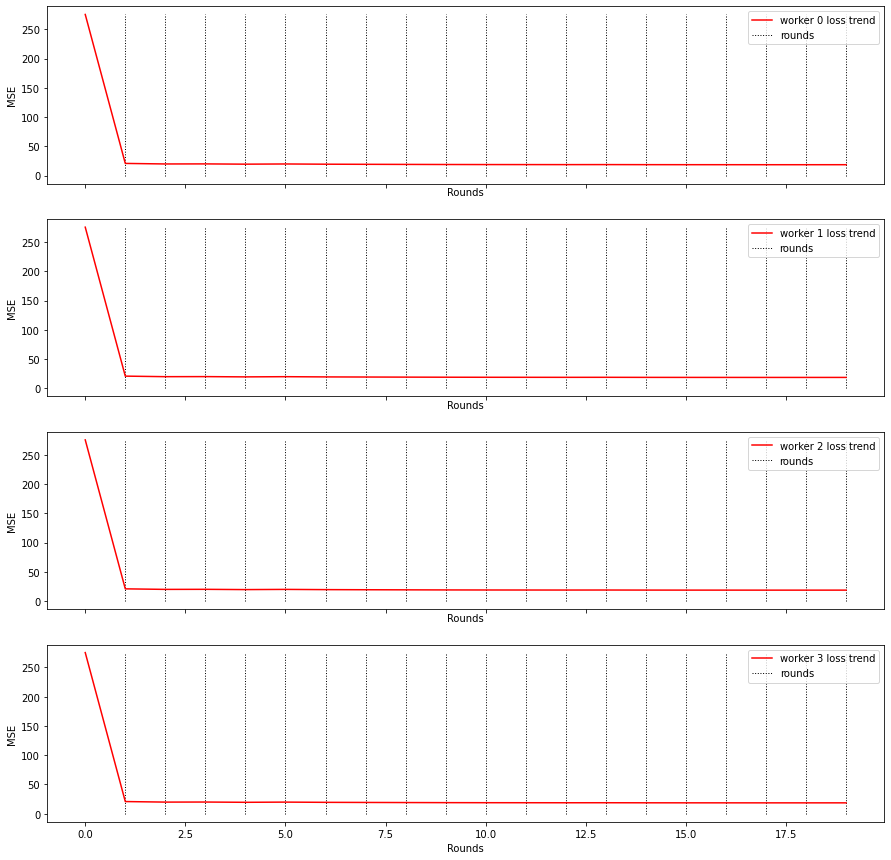

In [8]:
# plot loss over epochs for each worker

fig, axs = plt.subplots(num_workers, 1, sharex=True, figsize=(15, 15))
for k, v in worker_losses_dict.items():
    axs[k].plot(v, label = "worker {} loss trend".format(k), color = 'red')
    axs[k].set_xlabel("Rounds")
    axs[k].set_ylabel("MSE")
    
    axs[k].vlines((np.arange(num_rounds))[1:], ymin = 0, ymax = np.max(v), linewidth=1, linestyle=':', label = 'rounds')
    
    axs[k].legend()


plt.savefig("loss_trend_linearRegression.pdf", bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

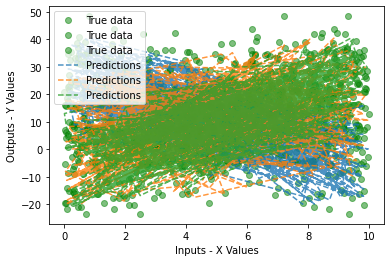

In [8]:
plt.clf()
ax = plt.figure().gca()

plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, pred_server, '--', label='Predictions', alpha=0.8)
plt.legend(loc='best')

ax.set_xlabel("Inputs - X Values")
ax.set_ylabel("Outputs - Y Values")

plt.show()

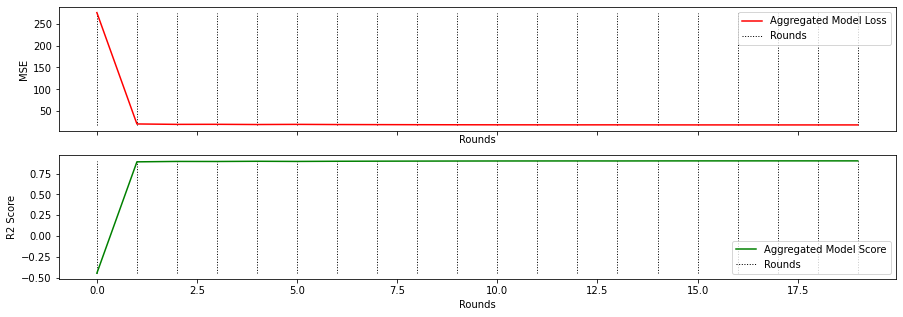

In [9]:
e = np.asarray(error)
a = np.asarray(score)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

axs[0].plot(e, label = "Aggregated Model Loss", color = 'red')
axs[0].set_xlabel("Rounds")
axs[0].set_ylabel("MSE")
axs[0].vlines((np.arange(num_rounds))[0:], ymin = np.min(e), ymax = np.max(e), linewidth=1, linestyle=':', label = 'Rounds')
axs[0].legend()

axs[1].plot(a, label = "Aggregated Model Score", color = 'green')
axs[1].set_xlabel("Rounds")
axs[1].set_ylabel("R2 Score")
axs[1].vlines((np.arange(num_rounds))[0:], ymin = np.min(a), ymax = np.max(a), linewidth=1, linestyle=':', label = 'Rounds')
axs[1].legend()

plt.savefig("Score_trend_LinearRegression.pdf", bbox_inches='tight')

# Federated Averaging

Implementation of FedAVG in PyTorch. 

First of all, the dataset is converted in tensors.
Then, a model, a loss function and an optimizer are instantiated for each worker.
Model parameters are averaged at each round.

In [10]:
from torch.autograd import Variable

for i in range(0, len(train_list_X)):
    train_list_X[i] = torch.from_numpy(train_list_X[i])

for i in range(0, len(train_list_y)):
    train_list_y[i] = torch.from_numpy(train_list_y[i])

## Model


In [11]:
import torch.nn.functional as F
import copy

class customModel(torch.nn.Module):
    
    def __init__(self, inputSize, outputSize, H = 10):
        
        super(customModel, self).__init__()
        self.linear = torch.nn.Linear(inputSize, H, bias=True)
        self.linear2 = torch.nn.Linear(H, outputSize)

        
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.linear2(x)
        return x


In [11]:
import torch.nn.functional as F
import copy

class customModel(torch.nn.Module):
    
    def __init__(self, inputSize, outputSize, H = 10):
        
        super(customModel, self).__init__()
        self.linear = torch.nn.Linear(inputSize, H, bias=True)
        self.linear2 = torch.nn.Linear(H, outputSize)

        
    def forward(self, x):
        x = self.linear(x)
        x = self.linear2(x)
        return x

In [13]:
"""
w = []

for i in range(0, num_workers):
    
    w.append(customModel(dataset_X[0].size, dataset_y[0].size))
    w[i] = w[i].float()

"""

w = []

w.append(customModel(dataset_X[0].size, dataset_y[0].size))

for i in range(1, num_workers):
    
    w.append(copy.deepcopy(w[0]))
    #w[i] = w[i].float()

In [14]:
learning_rate = 1e-4
local_epochs = 500

criterion = []
optimizers = []

for i in w:
    
    criterion.append(torch.nn.MSELoss()) 
    #optimizers.append(torch.optim.SGD(i.parameters(), lr=learning_rate))
    optimizers.append(torch.optim.lr_scheduler.StepLR(torch.optim.SGD(i.parameters(), lr=learning_rate),
                                                      step_size = local_epochs,
                                                      gamma=0.5))

In [15]:
params = []


for i in w:
    params.append(list(i.parameters()))

In [16]:
# VERSION WITH LR DECAY

from collections import defaultdict


errora = []
scorea = []


for model in w:
    model.train()
    

# stores losses trend for each worker along epochs
worker_losses_dict = defaultdict(list)


for i in range(num_rounds):
    
    print("\n## ## ## ROUND {} ## ## ##\n".format(i))
    
    for j in range(0, num_workers):
        
        #print("# # # WORKER {} # # #\n".format(j))
        
        
        for epoch in range(local_epochs):
            
            optimizers[j].optimizer.zero_grad()
            loss = 0
            
            for x in range(len(train_list_X[i*num_workers+j])):
                inputs = (train_list_X[i*num_workers+j][x]).float()
                inputs = inputs.unsqueeze(0)
                labels = (train_list_y[i*num_workers+j][x]).float()
                labels = labels.unsqueeze(0)
                y_pred = w[j](inputs)
                loss += criterion[j](y_pred, labels)
            
            # store loss info for current epoch 
            worker_losses_dict[j].append(loss)
            
            loss.backward()
            optimizers[j].optimizer.step()
            optimizers[j].step()
            
        
        print("loss:\t{}".format(loss))    
    
    
    new_params = list()

    for param_i in range(len(params[0])):

        spdz_params = list()

        for remote_index in range(len(w)):
            spdz_params.append(params[remote_index][param_i])
        
        spdz = torch.tensor([0.0]).float()

        for k in spdz_params:
            spdz = spdz + k
        
        new_param = (spdz) / len(w)
        new_params.append(new_param)
    
    
    #tensor_params = torch.FloatTensor(params).float()
    #tensor_new_params = torch.FloatTensor(new_params).float()
    
    #for n in range(0, num_workers):
    #    print("## WORKER {}: weights norm".format(n))
    #    print(torch.norm(tensor_params[n]-tensor_new_params))
    
    with torch.no_grad():
        #for model in params:
        #    for param in model:
        #        param *= 0
        
        for remote_index in range(len(w)):
            for param_index in range(len(params[remote_index])):
                #params[remote_index][param_index].set_(new_params[param_index])
                params[remote_index][param_index] = new_params[param_index].data.clone() #torch.nn.Parameter(new_params[param_index])
    
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()
    
    print('------ROUND {}------'.format(i))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, predicted))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, predicted))
    errora.append(mean_squared_error(test_y, predicted))
    scorea.append(r2_score(test_y, predicted))


## ## ## ROUND 0 ## ## ##

loss:	390.5931091308594
loss:	372.6729736328125
loss:	407.5846252441406
loss:	406.7402038574219
------ROUND 0------
Mean squared error: 31.476
Coefficient of determinaton: 0.835 


## ## ## ROUND 1 ## ## ##

loss:	270.234619140625
loss:	383.3151550292969
loss:	554.8284912109375
loss:	466.8479919433594
------ROUND 1------
Mean squared error: 27.311
Coefficient of determinaton: 0.857 


## ## ## ROUND 2 ## ## ##

loss:	285.98333740234375
loss:	397.5700988769531
loss:	194.29360961914062
loss:	400.22222900390625
------ROUND 2------
Mean squared error: 20.976
Coefficient of determinaton: 0.890 


## ## ## ROUND 3 ## ## ##

loss:	353.9266357421875
loss:	514.2183837890625
loss:	465.78656005859375
loss:	314.98504638671875
------ROUND 3------
Mean squared error: 22.987
Coefficient of determinaton: 0.879 


## ## ## ROUND 4 ## ## ##

loss:	289.1488037109375
loss:	176.60882568359375
loss:	393.97308349609375
loss:	318.1848449707031
------ROUND 4------
Mean squared error

In [92]:
"""from collections import defaultdict

local_epochs = 500

errora = []
scorea = []


for model in w:
    model.train()
    

# stores losses trend for each worker along epochs
worker_losses_dict = defaultdict(list)


for i in range(num_rounds):
    
    print("\n## ## ## ROUND {} ## ## ##\n".format(i))
    
    for j in range(0, num_workers):
        
        #print("# # # WORKER {} # # #\n".format(j))
        
        
        for epoch in range(local_epochs):
            
            optimizers[j].zero_grad()
            loss = 0
            
            for x in range(len(train_list_X[i*num_workers+j])):
                inputs = (train_list_X[i*num_workers+j][x]).float()
                inputs = inputs.unsqueeze(0)
                labels = (train_list_y[i*num_workers+j][x]).float()
                labels = labels.unsqueeze(0)
                y_pred = w[j](inputs)
                loss += criterion[j](y_pred, labels)
            
            # store loss info for current epoch 
            worker_losses_dict[j].append(loss)
            
            loss.backward()
            optimizers[j].step()
        
        print("loss:\t{}".format(loss))    
    
    
    new_params = list()

    for param_i in range(len(params[0])):

        spdz_params = list()

        for remote_index in range(len(w)):
            spdz_params.append(params[remote_index][param_i])
        
        spdz = torch.tensor([0.0]).float()

        for k in spdz_params:
            spdz = spdz + k
        
        new_param = (spdz) / len(w)
        new_params.append(new_param)
    
    
    #tensor_params = torch.FloatTensor(params).float()
    #tensor_new_params = torch.FloatTensor(new_params).float()
    
    #for n in range(0, num_workers):
    #    print("## WORKER {}: weights norm".format(n))
    #    print(torch.norm(tensor_params[n]-tensor_new_params))
    
    with torch.no_grad():
        #for model in params:
        #    for param in model:
        #        param *= 0
        
        for remote_index in range(len(w)):
            for param_index in range(len(params[remote_index])):
                #params[remote_index][param_index].set_(new_params[param_index])
                params[remote_index][param_index] = new_params[param_index].data.clone() #torch.nn.Parameter(new_params[param_index])
    
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()
    
    print('------ROUND {}------'.format(i))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, predicted))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, predicted))
    errora.append(mean_squared_error(test_y, predicted))
    scorea.append(r2_score(test_y, predicted))

"""


## ## ## ROUND 0 ## ## ##



AttributeError: 'StepLR' object has no attribute 'zero_grad'

<Figure size 432x288 with 0 Axes>

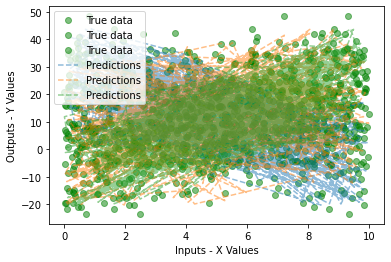

In [16]:
with torch.no_grad(): 
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()

plt.clf()
ax = plt.figure().gca()

plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, predicted,'--', label='Predictions', alpha=0.5)

ax.set_xlabel("Inputs - X Values")
ax.set_ylabel("Outputs - Y Values")

plt.legend(loc='best')
plt.show()

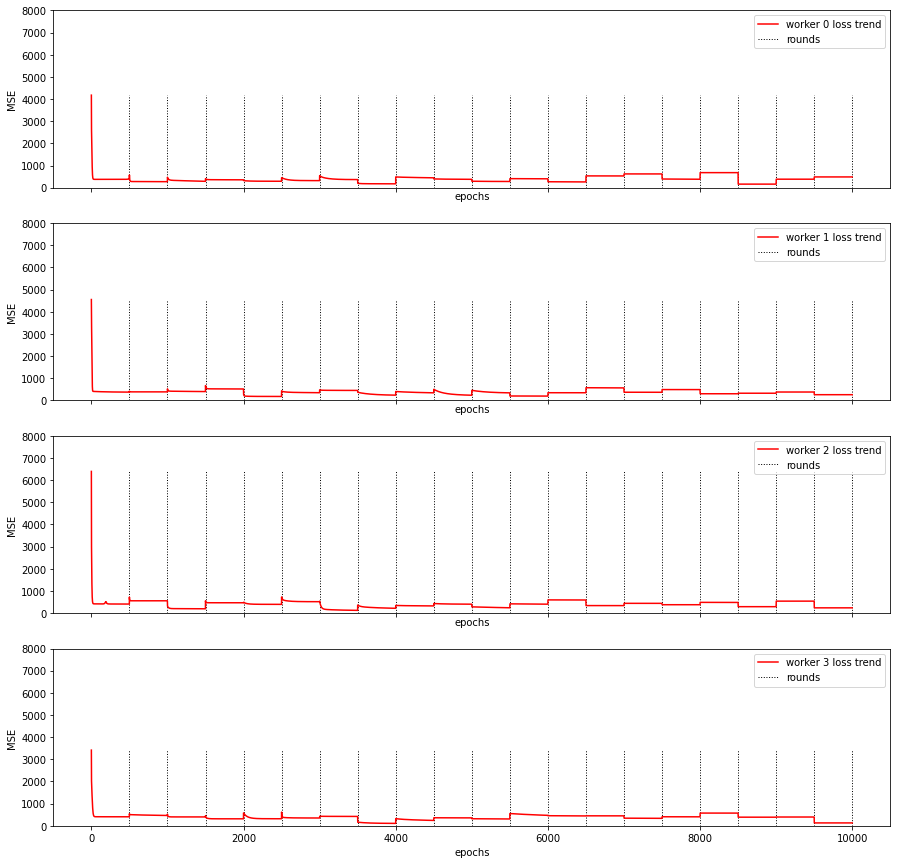

In [17]:
# plot loss over epochs for each worker

fig, axs = plt.subplots(num_workers, 1, sharex=True, figsize=(15, 15))
for k, v in worker_losses_dict.items():
    axs[k].plot(v, label = "worker {} loss trend".format(k), color = 'red')
    axs[k].set_xlabel("epochs")
    axs[k].set_ylabel("MSE")
    
    axs[k].vlines((np.arange(num_rounds+1)*local_epochs)[1:], ymin = 0, ymax = np.max(v), linewidth=1, linestyle=':', label = 'rounds')
    
    axs[k].legend()
    
    axs[k].set_ylim([0, 8000])


plt.savefig("loss_trend.pdf", bbox_inches='tight')

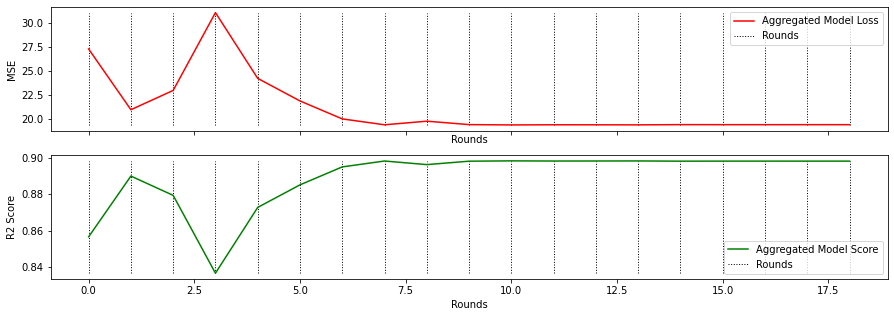

In [18]:
e = (np.asarray(errora))[1:]
a = (np.asarray(scorea))[1:]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

axs[0].plot(e, label = "Aggregated Model Loss", color = 'red')
axs[0].set_xlabel("Rounds")
axs[0].set_ylabel("MSE")
axs[0].vlines((np.arange(num_rounds-1))[0:], ymin = np.min(e), ymax = np.max(e), linewidth=1, linestyle=':', label = 'Rounds')
axs[0].legend()

axs[1].plot(a, label = "Aggregated Model Score", color = 'green')
axs[1].set_xlabel("Rounds")
axs[1].set_ylabel("R2 Score")
axs[1].vlines((np.arange(num_rounds-1))[0:], ymin = np.min(a), ymax = np.max(a), linewidth=1, linestyle=':', label = 'Rounds')
axs[1].legend()

plt.savefig("Score_trend_LinearRegression.pdf", bbox_inches='tight')

In [19]:
N = len(test_X)
p = len(test_X[0]) + 1


X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = test_X

beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ test_y

y_hat = pred_server
residuals = test_y - y_hat
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
print("--- CUSTOM ALGORITHM ---")
print("Coefficients: {} {}".format(beta_hat[0], beta_hat[1]))
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(coeff[{p_}]): {standard_error}")
print("--- --------- ---") 
    


X_with_intercept = np.empty(shape=(N, p), dtype=np.float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = test_X

beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ test_y

y_hat = predicted
residuals = test_y - y_hat
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
print("\n\n--- FED AVG ---")
print("Coefficients: {} {}".format(beta_hat[0], beta_hat[1]))
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(coeff[{p_}]): {standard_error}")   

print("--- --------- ---") 

--- CUSTOM ALGORITHM ---
Coefficients: [1.7716824] [-3.05270304]
SE(coeff[0]): 0.6699000128446844
SE(coeff[1]): 0.0757635130795594
SE(coeff[2]): 0.076582914957434
SE(coeff[3]): 0.07474390091454146
--- --------- ---


--- FED AVG ---
Coefficients: [1.7716824] [-3.05270304]
SE(coeff[0]): 0.6838297721733143
SE(coeff[1]): 0.0773389235629959
SE(coeff[2]): 0.07817536391039336
SE(coeff[3]): 0.07629810979804527
--- --------- ---


<Figure size 720x360 with 0 Axes>

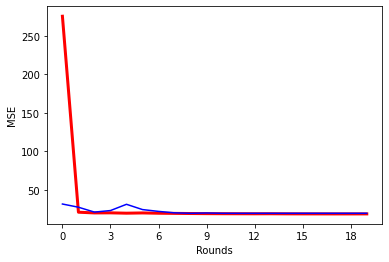

In [20]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

figure(figsize=(10,5))

e = (np.asarray(errora))#[1:]
a = (np.asarray(scorea))#[1:]


x = np.arange(num_rounds)

ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(x, error, color='red', linewidth=3)
plt.plot(x, errora, color='blue')

ax.set_xlabel("Rounds")
ax.set_ylabel("MSE")

plt.draw()

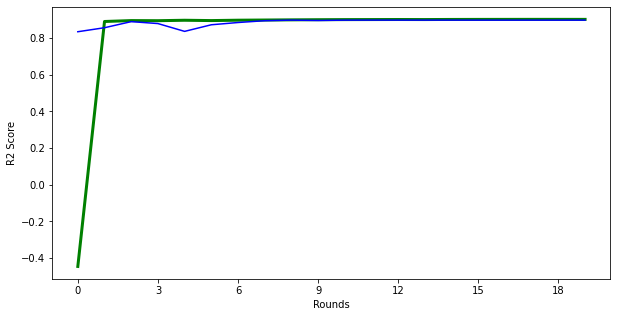

In [21]:
figure(figsize=(10,5))

x = np.arange(num_rounds)

plt.plot(x, score, color='green', linewidth=3)
plt.plot(x, scorea, color='blue')

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

#ax.set_ylim([0.5,1])

ax.set_xlabel("Rounds")
ax.set_ylabel("R2 Score")

plt.draw()